#### Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from ema_workbench import load_results, save_results
from ema_workbench.analysis import clusterer, plotting, Density

In [3]:
sns.set_style('white')

In [4]:
path = '../results/'
file_name = '2000_scen__AGGD_reps__0612'
file_ext  = '.tar.gz'

In [5]:
experiments, outcomes = load_results(path+file_name+file_ext)

In [6]:
[key for key in outcomes]

['MEAN(Household Population)',
 'STD(Household Population)',
 'VAR(Household Population)',
 'CI_95(Household Population)',
 'CI_5(Household Population)',
 'MEAN(GDP)',
 'STD(GDP)',
 'VAR(GDP)',
 'CI_95(GDP)',
 'CI_5(GDP)',
 'MEAN(Gini Coefficient)',
 'STD(Gini Coefficient)',
 'VAR(Gini Coefficient)',
 'CI_95(Gini Coefficient)',
 'CI_5(Gini Coefficient)']

In [7]:
oois = [out for out in outcomes if out[:3] != 'STD']
oois

['MEAN(Household Population)',
 'VAR(Household Population)',
 'CI_95(Household Population)',
 'CI_5(Household Population)',
 'MEAN(GDP)',
 'VAR(GDP)',
 'CI_95(GDP)',
 'CI_5(GDP)',
 'MEAN(Gini Coefficient)',
 'VAR(Gini Coefficient)',
 'CI_95(Gini Coefficient)',
 'CI_5(Gini Coefficient)']

### Univariate Clustering

1. ([This Notebook](Timeseries%20Clustering.ipynb)) For each major outcome of interest, perform time-series clustering. Do this for multiple k-values (# of clusters) and compare results, similar to Jafino & Kwakkel (2021). Select optimal k-number for each outcome.
2. ([Cluster Analysis](Cluster%20Analysis.ipynb)) Plot (using a matrix) the co-occurrence of clusters across different variables to see if there are noticeable patterns.
3. ([Cluster Rule Induction](Cluster%20Rule%20Induction.ipynb)) Perform PRIM (for now) on each cluster, for each variable, to look for predictive/explanatory input spaces. Stick to the input spaces (for now).

Other notes:
* Test it with both the full time-series and with cutting off the first 20 steps (burn-in).

#### Calculate Complex-Invariate Distances

As a benchmark, this took 21 minutes to find the distances in 3 outcomes for a 10000-scenario run.

In [8]:
distances = {}

In [9]:
for ooi in oois:
    # Calculate TS distances
    data = outcomes[ooi]
    distances[ooi] = clusterer.calculate_cid(data)
    
    # NB: Saving the distances requires A LOT of disk space.
    #      Specifically, num_runs^2*64 bits. For 10k runs, that's 6.4 GB.
    # pd.DataFrame(distances).to_csv("../results/clustering_distances/10k_run_0605__household_population__distances.csv")

#### Compute clusters for a range of K-values

For each one, calculate the *explained variance*, as well as the *increase in explained variance gained by moving from K=k-1 to K=k*.

In [10]:
min_K = 2
max_K = 21 

In [11]:
all_clusters = {ooi:{} for ooi in oois}
explained_variances = {ooi:{} for ooi in oois}
delta_EVs = {ooi:{} for ooi in oois}

for ooi in oois:
    # Calculate overall centroid
    overall_centroid = outcomes[ooi].mean(axis=0)
    # Calculate sum mean squared error for total dataset
    assert(len(outcomes[ooi][0]) == len(overall_centroid))
    MSEs_all = [np.power(run - overall_centroid, 2).mean() for run in outcomes[ooi]]

    SMSE_all = sum(MSEs_all)
    # print(f"{ooi} has overall SMSE of {SMSE_all:.3}")

    # Test across K values (candidate #s of clusters)
    prev_EV = 0
    for K in range(min_K, max_K): 
        # Compute clusters
        all_clusters[ooi][K] = clusterer.apply_agglomerative_clustering(distances[ooi], n_clusters=K)

        # Calculate within-cluster error (sum mean squared error)
        runs_by_cluster = [[] for clust in range(K)]
        for n, run in enumerate(outcomes[ooi]):
            clust = all_clusters[ooi][K][n]
            runs_by_cluster[clust].append(run)
        runs_by_cluster = [np.array(runs) for runs in runs_by_cluster]

        SMSEs_within = []
        for clust in range(K):
            runs = runs_by_cluster[clust]
            clust_centroid = runs.mean(axis=0)
            MSEs_within = [np.power(run - clust_centroid, 2).mean() for run in runs]
            SMSEs_within.append(sum(MSEs_within))

        explained_variances[ooi][K] = 1 - (sum(SMSEs_within) / SMSE_all)

        delta_EVs[ooi][K] = explained_variances[ooi][K] - prev_EV
        prev_EV = explained_variances[ooi][K]
        # print(f":: K={K} produces within-cluster SMES of {SMSEs_within}")
        # print(f":: K={K} produces explained variance EV_K={explained_variances[ooi][K]}")


#### Plot elbow curves to visualize cluster performance convergence

In [12]:
# Reconfigure data into plot-friendly format
index = [K for K in range(min_K, max_K)]

# ALT METHOD: Produces separate DF per OOI.
# dfs = {}
# for ooi in oois:
#     # EV_as_list = [EV for _, EV in explained_variances[ooi].items()]
#     # delta_EV_as_list = [d_EV for _, d_EV in delta_EVs[ooi].items()]

#     dfs[ooi] = pd.DataFrame({
#             'Explained variance':[EV for _, EV in explained_variances[ooi].items()],
#             'Change in explained variance':[d_EV for _, d_EV in delta_EVs[ooi].items()]
#         },
#         index=index
#     )

# PREFERRED METHOD: Produces one DF for EV and one for delta_EV.
EV_lists = {ooi:[EV for _, EV in explained_variances[ooi].items()] for ooi in oois}
delta_EV_lists = {ooi:[d_EV for _, d_EV in delta_EVs[ooi].items()] for ooi in oois}

EV_lists['K'] = delta_EV_lists['K'] = index

EV_df = pd.DataFrame(EV_lists)
delta_EV_df = pd.DataFrame(delta_EV_lists)

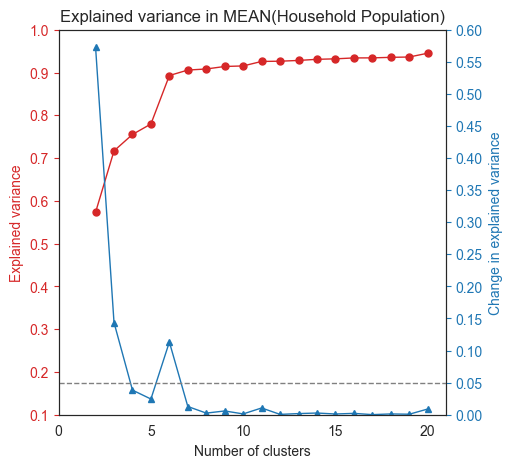

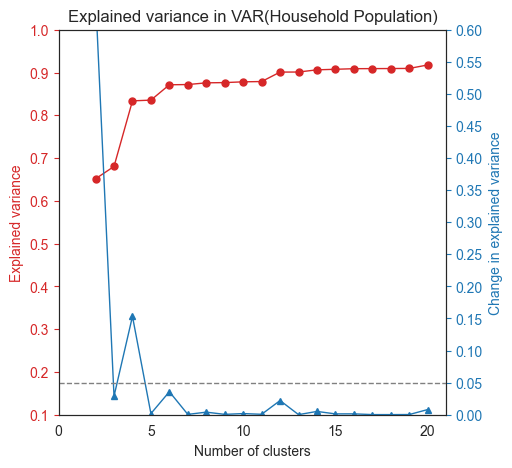

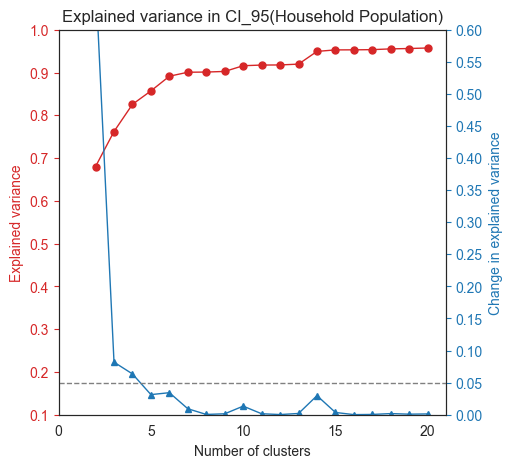

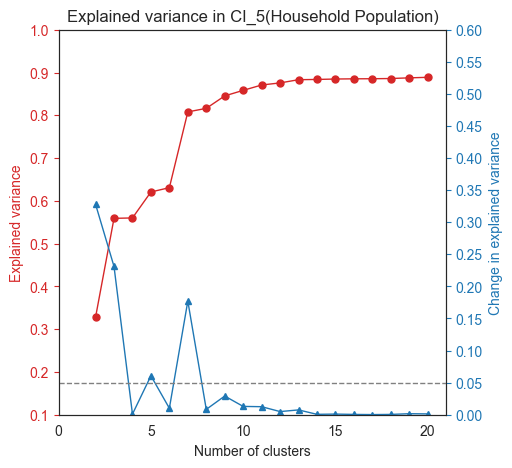

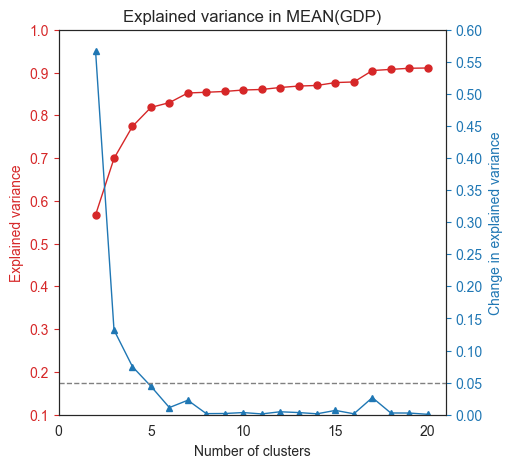

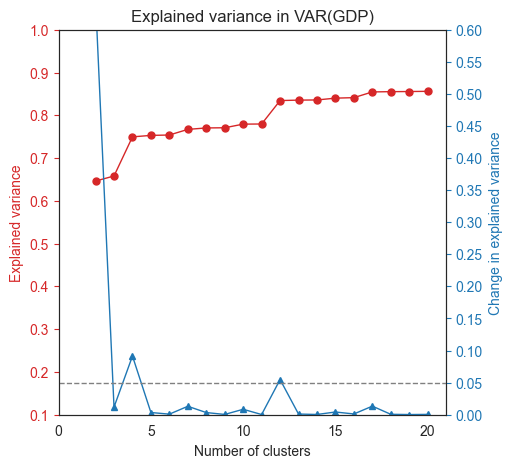

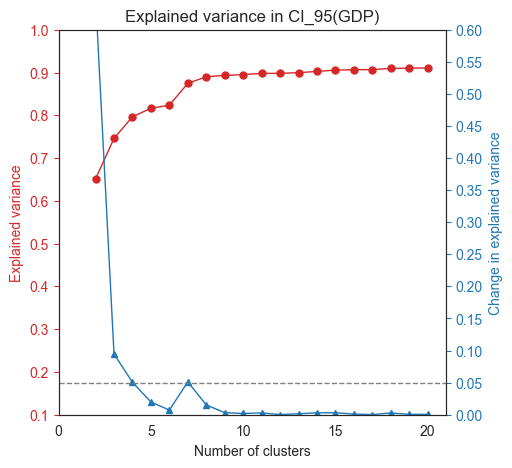

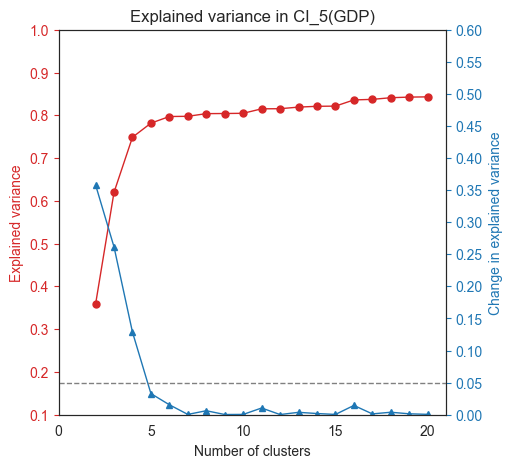

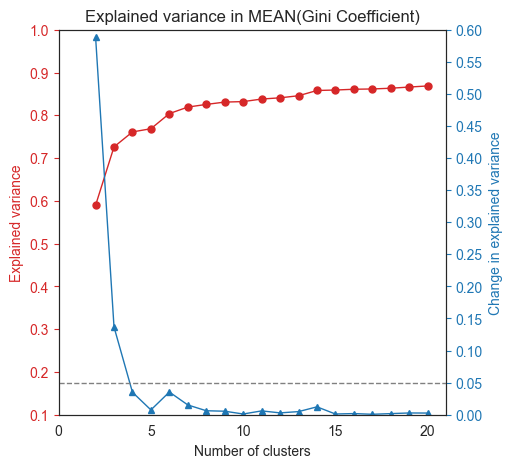

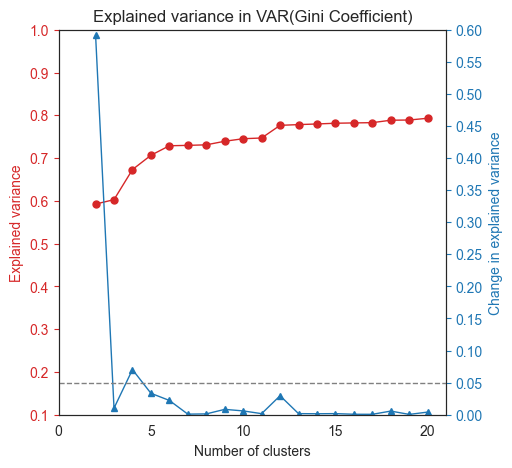

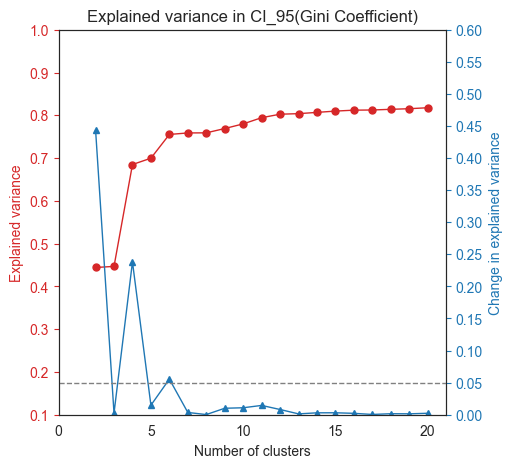

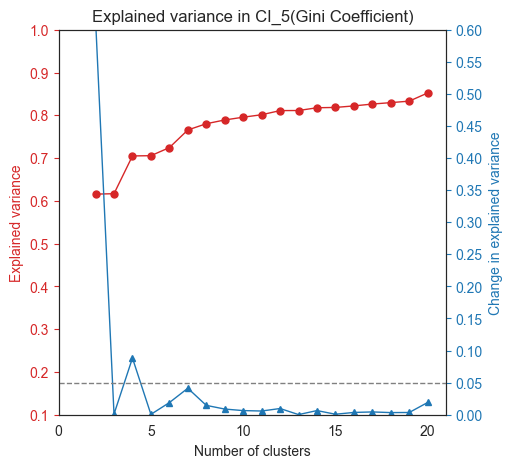

In [13]:
# Plot! 
for ooi in oois:
    # Create plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(5,5))
    ax2 = ax1.twinx()

    # Set up x-axis
    ax1.set_xlim([0, max_K])
    ax1.set_xticks([K for K in range(0, max_K, 5)])
    ax1.set_xlabel('Number of clusters')

    # Plot EV and set up its axis
    ax1.plot(index, EV_df[ooi], 'o-', color='tab:red', linewidth=1, markersize=5)
    ax1.set_ylim([0.1, 1.0])
    ax1.set_ylabel('Explained variance', color='tab:red')
    ax1.set_yticks([(i+1)/10 for i in range(10)])
    ax1.tick_params(axis='y', color='tab:red', labelcolor='tab:red')

    # Plot delta_EV and set up its axis
    ax2.plot(index, delta_EV_df[ooi], '^-', color="tab:blue", linewidth=1, markersize=5)
    ax2.set_ylim([0, 0.6])
    ax2.set_ylabel('Change in explained variance', color='tab:blue')
    ax2.set_yticks([(i)/20 for i in range(13)])
    ax2.tick_params(axis='y', color='tab:blue', labelcolor='tab:blue')

    # Add elbow cut-off point
    ax2.hlines(y=0.05, xmin=0, xmax=max_K, colors='grey', linestyles={'dashed'}, linewidth=1)

    # Final steps
    plt.title(f"Explained variance in {ooi}") #, K=[{min_K}, {max_K}]")
    plt.show()
    # plt.savefig('../img/filename.png')

#### Select optimal K and save results to a file

In [21]:
for ooi in oois:
    for K in range(min_K+1, max_K):
        if delta_EVs[ooi][K] < 0.05:
            experiments[f"Cluster ({ooi})"] = all_clusters[ooi][K-1].astype("object")
            break

In [22]:
experiments.head()

,debt_sales_ratio,wage_sensitivity_prod,init_markup,capital_firm_cap_out_ratio,min_unempl_emigration,migration_unempl_bounds_diff,deu_discount_factor,flood_timing,scenario,policy,...,Cluster (CI_95(Household Population)),Cluster (CI_5(Household Population)),Cluster (MEAN(GDP)),Cluster (VAR(GDP)),Cluster (CI_95(GDP)),Cluster (CI_5(GDP)),Cluster (MEAN(Gini Coefficient)),Cluster (VAR(Gini Coefficient)),Cluster (CI_95(Gini Coefficient)),Cluster (CI_5(Gini Coefficient))
0,3.974297,0.712775,0.099379,0.297524,0.040977,0.136866,0.956540,33.0,0,NaN,...,0,0,0,0,0,2,0,1,0,1
1,4.388648,0.624767,0.069494,0.246466,0.031566,0.160825,0.857878,76.0,1,NaN,...,0,2,0,0,0,0,0,0,1,1
2,3.970944,0.929448,0.489306,0.339357,0.051214,0.166170,0.954534,34.0,2,NaN,...,1,0,3,1,1,1,1,1,0,0
3,0.972112,0.595822,0.229186,0.399390,0.058033,0.145984,0.827532,46.0,3,NaN,...,0,0,0,1,1,3,2,1,0,1
4,2.097049,0.085739,0.102101,0.530068,0.059356,0.146438,0.858569,72.0,4,NaN,...,0,2,0,0,2,0,0,0,1,1


In [23]:
results = experiments, outcomes
save_results(results, path+file_name+'__with_clusters'+file_ext)

c:\Users\Gabriel\Documents\Academic\EPA\2. Thesis\Code\CRAB_EM\.venv\Lib\site-packages\ema_workbench\em_framework\outcomes.py:540: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
